# 18. Offline Reinforcement Learning (ORL)

## 18.1. Intro
离线强化学习

## 18.2. Batch-Constrained Q-Learning (BCQ) Algo

批量限制Q-learning算法

标准Q-learning
$$
Q(s, a) \leftarrow (1 - \alpha)Q(s, a) + \alpha(r + \gamma Q(s', \argmax_{a'}Q(s', a')))
$$
BCQ:
$$
Q(s, a) \leftarrow (1 - \alpha)Q(s, a) + \alpha(r + \gamma Q(s', \argmax_{a' \text{s.t.} (s', a') \in \mathcal{D}}Q(s', a')))
$$

$$
\pi(s) = \argmax_{a_i + \xi_\phi(s, a_i, \Phi)} Q_\theta(s, a_i + \xi_\phi(s, a_i, \Phi)), \{a_i \sim G_\omega(s)\}_{i=1}^n
$$

$\xi_\phi(s, a, \Phi)$: 扰动模型，$\Phi$, 绝对值最大的扰动，$G_\omega(s)$: 变分自动编码器(variational auto-encoder VAE), 

$$
\phi = \argmax_\phi\sum_{(s, a) \in \mathcal{D}}Q_\theta(s, a + \xi_\phi(s, a, \Phi))
$$

伪代码 MBPO：
1. 随机初始化Q网络$Q_\theta$, 扰动网络$\xi_\phi$, 生成网络$G_\omega = \{E_{\omega_1}, D_{\omega_2}\}$
2. 用$\theta$初始化目标网络$Q_{\theta^-}$, 用$\phi$初始化目标扰动网络$\xi_{\phi'}$
3. **for** 训练次数$e = 1 \rightarrow E$ **do**
   1. 从数据集$\mathcal{D}$采用一定数量$(s, a, r, s')$
   2. 编码生成均值和标准差$\mu, sigma = E_{\omega_1}(s, a)$
   3. 编码器生成动作$\tilde{a} = D_{\omega_2}(s, z)$, 其中$z \sim \mathcal{N}(\mu, sigma)$
   4. 更新生成模型：$\omega \leftarrow \argmin_\omega\sum(a - \tilde{a})^2 + D_{KL}(\mathcal{N}(\mu, \sigma) || \mathcal{N}(0, 1))$
   5. 从生成模型中采样$n$个动作: $\{a_i \sim G_\omega(s')\}_{i=1}^n$
   6. 对每个动作施加扰动:$\{a_i \leftarrow a_i + \xi_\phi(s', a_i, \phi)\}_{i=1}^n$
   7. 计算$Q$网络的目标值$y = r + \gamma \max_{a_i} Q_{\theta^-}(s', a_i)$
   8. 更新$Q$网络: $\theta \leftarrow \argmin_\theta \sum(y - Q_\theta(s, a))^2$
   9. 更新扰动网络$\phi \leftarrow \argmax_\phi \sum Q_\theta(s, a + \xi_\phi(s, a, \Phi)), a \sim G_\omega(s)$
   10. 更新目标网络：$\theta^- \leftarrow \tau\theta + (1 - \tau)\theta^-$
   11. 更新扰动网络: $\phi' \leftarrow \tau\phi + (1 - \tau)\phi$
4. **end for**

## 18.3. Conservative Q-Learning (CQL)
保守Q-learning算法

标准Q-learning： 
$$
\hat{Q}^{k+1} \leftarrow \argmin_Q \mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2]
$$

$\hat{\mathcal{B}}^\pi$: 计算$\pi$的贝尔曼算子
$$
\hat{Q}^{k+1} \leftarrow \argmin_Q \beta\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)}[Q(s, a)] + \frac12\mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2]
$$

$\beta$: 平衡因子
$$
\hat{Q}^{k+1} \leftarrow \argmin_Q \beta \cdot (\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)}[Q(s, a)] - \mathbb{E}_{s \sim \mathcal{D}, a \sim \hat{\pi}_b(a|s)}[Q(s, a)])+ \frac12\mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2]
$$
$\pi_b$策略

$\pi \approx \max_\mu\mathbb{E}_{s\sim\mathcal{D}, a\sim\mu(a|s)}[Q(s, a)]$

$$
\hat{Q}^{k+1} \leftarrow \argmin_Q \max_\mu \beta \cdot (\mathbb{E}_{s \sim \mathcal{D}, a \sim \mu(a|s)}[Q(s, a)] - \mathbb{E}_{s \sim \mathbb{D}, a \sim \hat{\pi}_b(a|s)}[Q(s, a)]) + \frac12\mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2]
$$

$$
\hat{Q}^{k+1} \leftarrow \argmin_Q \beta \cdot \mathbb{E}_{s \sim \mathcal{D}}[\log\sum_a e^{Q(s, a)} - \mathbb{E}_{a \sim \hat{\pi}_b(a|s)}[Q(s, a)]] + \frac12\mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2]
$$

伪代码 CQL：
1. 初始化Q网络$Q_\theta$, 目标网络$Q_{\theta'}$和策略$\pi_\phi$, 熵正则系数$\alpha$
2. **for** 训练次数$t = 1 \rightarrow T$ **do**
   1. 更新熵正则系数: $\alpha_t \leftarrow \alpha_{t-1} - \eta_\alpha\nabla_\alpha\mathbb{E}_{s\sim\mathcal{D}, a \sim\pi_\phi(a|s)}[-\alpha_{t-1}\log\pi_\phi(a|s) - \alpha_{t-1}\mathcal{H}]$
   2. 更新$Q$: $\theta \leftarrow \theta_{t-1} - \eta_Q\nabla_\theta(\alpha \cdot \mathbb{E}_{s \sim \mathcal{D}}[\log\sum_a e^{Q(s, a)} - \mathbb{E}_{a \sim \hat{\pi}_b(a|s)}[Q(s, a)]] + \frac12\mathbb{E}_{(s, a) \sim \mathcal{D}}[(Q(s, a) - \hat{\mathcal{B}}^\pi\hat{Q}^k(s, a))^2])$
   3. 更新策略：$\phi' \leftarrow \phi_{t-1} - \eta_\pi\nabla_\phi\tau\mathbb{E}_{s \sim \mathcal{D}, a \sim \pi_\phi(a|s)}[\alpha \log \pi_\phi(a|s) - Q_\theta(s, a)]$
3. **end for**

In [1]:
import numpy as np
if not hasattr(np, "bool8"):
  np.bool8 = np.bool_ # 这样写np不用降级
import gym
from tqdm import tqdm
import random
import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
class PolicyNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
    super(PolicyNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
    self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
    self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
    self.action_bound = action_bound
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    mu = self.fc_mu(x)
    std = F.softplus(self.fc_std(x))
    dist = Normal(mu, std)
    normal_sample = dist.rsample() # rsample()是重参数化采样
    log_prob = dist.log_prob(normal_sample)
    action = torch.tanh(normal_sample)
    # 计算tanh_normal分布的对数概率密度
    log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
    action = action * self.action_bound
    return action, log_prob
  
class QValueNetContinuous(torch.nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(QValueNetContinuous, self).__init__()
    self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
    self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.fc_out = torch.nn.Linear(hidden_dim, 1)
  
  def forward(self, x, a):
    cat = torch.cat([x, a], dim=1)
    x = F.relu(self.fc1(cat))
    x = F.relu(self.fc2(x))
    return self.fc_out(x)


class SACContinuous:
  """ 连续动作的SAC算法 """
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
              actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, 
              device):
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device) # 策略网络
    self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第一个Q网络
    self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第二个Q网络
    self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    
    # 令目标Q网络的初始参数和Q网络一样
    self.target_critic_1.load_state_dict(self.critic_1.state_dict())
    self.target_critic_2.load_state_dict(self.critic_2.state_dict())
    
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
    self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
    
    # 使用alpha的log值,可以使训练结果比较稳定
    self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
    self.log_alpha.requires_grad = True # 可以对alpha求梯度
    self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
    self.target_entropy = target_entropy # 目标熵的大小
    self.gamma = gamma
    self.tau = tau
    self.device = device
    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(self.device)
    action = self.actor(state)[0]
    return [action.item()]
  
  def calc_target(self, rewards, next_states, dones): #  计算目标Q值
    next_actions, log_prob = self.actor(next_states)
    entropy = -log_prob
    q1_value = self.target_critic_1(next_states, next_actions)
    q2_value = self.target_critic_2(next_states, next_actions)
    next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
    td_target = rewards + self.gamma * next_value * (1 - dones)
    return td_target
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau) 
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
    actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(self.device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
    rewards = (rewards + 8.0) /8.0
    
    # 更新两个Q网络
    td_target = self.calc_target(rewards, next_states, dones)
    critic_1_loss = torch.mean(
      F.mse_loss(self.critic_1(states, actions), td_target.detach())
    )
    critic_2_loss = torch.mean(
      F.mse_loss(self.critic_2(states, actions), td_target.detach())
    )
    self.critic_1_optimizer.zero_grad()
    critic_1_loss.backward()
    self.critic_1_optimizer.step()
    self.critic_2_optimizer.zero_grad()
    critic_2_loss.backward()
    self.critic_2_optimizer.step()
    
    # 更新策略网络
    new_actions, log_prob = self.actor(states)
    entropy = -log_prob
    q1_value = self.critic_1(states, new_actions)
    q2_value = self.critic_2(states, new_actions)
    actor_loss = torch.mean(-self.log_alpha.exp() * entropy 
                            - torch.min(q1_value, q2_value))
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    # 更新alpha值
    alpha_loss = torch.mean(
      (entropy - self.target_entropy).detach() * self.log_alpha.exp()
    )
    self.log_alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.log_alpha_optimizer.step()
    
    self.soft_update(self.critic_1, self.target_critic_1)
    self.soft_update(self.critic_2, self.target_critic_2)
    
env_name= "Pendulum-v1"
env = gym.make(env_name)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
action_bound = env.action_space.high[0]
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005 # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

Iteration 0:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\dell\AppData\Local\Temp\ipykernel_52388\3348398129.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it, episode=100, return=-192.690]


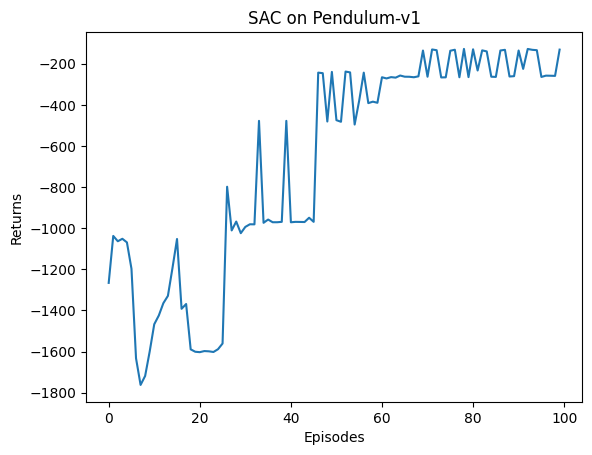

In [3]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [4]:
class CQL:
  """ CQL算法 """
  def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
              actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma, 
              device, beta, num_random):
    self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim, action_bound).to(device) # 策略网络
    self.critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第一个Q网络
    self.critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) #  第二个Q网络
    self.target_critic_1 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    self.target_critic_2 = QValueNetContinuous(state_dim, hidden_dim, action_dim).to(device) # 第一个目标Q网络
    
    # 令目标Q网络的初始参数和Q网络一样
    self.target_critic_1.load_state_dict(self.critic_1.state_dict())
    self.target_critic_2.load_state_dict(self.critic_2.state_dict())
    
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
    
    self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(), lr=critic_lr)
    self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(), lr=critic_lr)
    
    # 使用alpha的log值,可以使训练结果比较稳定
    self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
    self.log_alpha.requires_grad = True # 可以对alpha求梯度
    self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=alpha_lr)
    self.target_entropy = target_entropy # 目标熵的大小
    self.gamma = gamma
    self.tau = tau
    
    self.beta = beta # CQL损失函数中的系数
    self.num_random = num_random # CQL中的动作采样数

    
  def take_action(self, state):
    state = torch.tensor([state], dtype=torch.float).to(device)
    action = self.actor(state)[0]
    return [action.item()]
  
  def soft_update(self, net, target_net):
    for param_target, param in zip(target_net.parameters(), net.parameters()):
      param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau) 
  
  def update(self, transition_dict):
    states = torch.tensor(transition_dict['states'], dtype=torch.float).to(device)
    actions = torch.tensor(transition_dict['actions'], dtype=torch.float).view(-1, 1).to(device)
    rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(device)
    next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(device)
    dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(device)
    rewards = (rewards + 8.0) /8.0
    
    next_actions, log_prob = self.actor(states)
    entropy = -log_prob
    q1_value = self.target_critic_1(next_states, next_actions)
    q2_value = self.target_critic_2(next_states, next_actions)
    next_value = torch.min(q1_value, q2_value) + self.log_alpha.exp() * entropy
    # 更新两个Q网络
    td_target = rewards + self.gamma * next_value * (1 - dones)
    critic_1_loss = torch.mean(
      F.mse_loss(self.critic_1(states, actions), td_target.detach())
    )
    critic_2_loss = torch.mean(
      F.mse_loss(self.critic_2(states, actions), td_target.detach())
    )
    
    # 以下是CQL的额外部分
    batch_size = states.shape[0]
    random_unif_actions = torch.rand(
      [batch_size * self.num_random, actions.shape[-1]],
      dtype=torch.float
    ).uniform_(-1, 1).to(device)
    random_unif_log_pi = np.log(0.5**next_actions.shape[-1])
    tmp_states = states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, states.shape[-1])
    tmp_next_states = next_states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, next_states.shape[-1])
    random_curr_actions, random_curr_log_pi = self.actor(tmp_states)
    random_next_actions, random_next_log_pi = self.actor(tmp_next_states)
    q1_unif = self.critic_1(tmp_states, random_unif_actions).view(-1, self.num_random, 1)
    q2_unif = self.critic_2(tmp_states, random_unif_actions).view(-1, self.num_random, 1)
    q1_curr = self.critic_1(tmp_states, random_curr_actions).view(-1, self.num_random, 1)
    q2_curr = self.critic_2(tmp_states, random_curr_actions).view(-1, self.num_random, 1)
    q1_next = self.critic_1(tmp_states, random_next_actions).view(-1, self.num_random, 1)
    q2_next = self.critic_2(tmp_states, random_next_actions).view(-1, self.num_random, 1)
    q1_cat = torch.cat([
      q1_unif - random_unif_log_pi,
      q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
      q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
    ], dim=1)
    q2_cat = torch.cat([
      q2_unif - random_unif_log_pi,
      q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
      q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
    ], dim=1)
    
    qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
    qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
    qf1_loss_2 = self.critic_1(states, actions).mean()
    qf2_loss_2 = self.critic_2(states, actions).mean()
    qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
    qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)
    
    self.critic_1_optimizer.zero_grad()
    qf1_loss.backward(retain_graph=True)
    self.critic_1_optimizer.step()
    self.critic_2_optimizer.zero_grad()
    qf2_loss.backward(retain_graph=True)
    self.critic_2_optimizer.step()
    
    # 更新策略网络
    new_actions, log_prob = self.actor(states)
    entropy = -log_prob
    q1_value = self.critic_1(states, new_actions)
    q2_value = self.critic_2(states, new_actions)
    actor_loss = torch.mean(-self.log_alpha.exp() * entropy 
                            - torch.min(q1_value, q2_value))
    self.actor_optimizer.zero_grad()
    actor_loss.backward()
    self.actor_optimizer.step()
    
    # 更新alpha值
    alpha_loss = torch.mean(
      (entropy - self.target_entropy).detach() * self.log_alpha.exp()
    )
    self.log_alpha_optimizer.zero_grad()
    alpha_loss.backward()
    self.log_alpha_optimizer.step()
    
    self.soft_update(self.critic_1, self.target_critic_1)
    self.soft_update(self.critic_2, self.target_critic_2)

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

beta = 5.0
num_random = 5
num_epochs = 100
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim, action_bound,
            actor_lr, critic_lr, alpha_lr, target_entropy, tau, 
            gamma, device, beta, num_random)
return_list = []
for i in range(10):
  with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
    for i_epoch in range(int(num_epochs / 10)):
      # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
      epoch_return = 0
      state, _ = env.reset(seed=0)
      done = False
      while not done:
        action = agent.take_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        epoch_return += reward
      return_list.append(epoch_return)
      
      for _ in range(num_trains_per_epoch):
        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
        transition_dict = {
          'states': b_s,
          'actions': b_a,
          'next_states': b_ns,
          'rewards': b_r,
          'dones': b_d
        }
        agent.update(transition_dict)
        
      if (i_epoch + 1) % 10 == 0:
        pbar.set_postfix({
          'epoch':
            '%d' % (num_epochs / 10 * i + i_epoch + 1),
          'return':
          '%.3f' % np.mean(return_list[-10:])
        })
      pbar.update(1)

Iteration 9: 100%|██████████| 10/10 [01:38<00:00,  9.83s/it, epoch=100, return=-489.745]


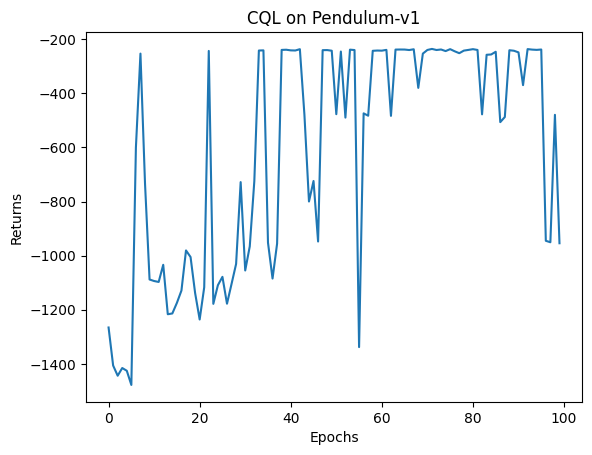

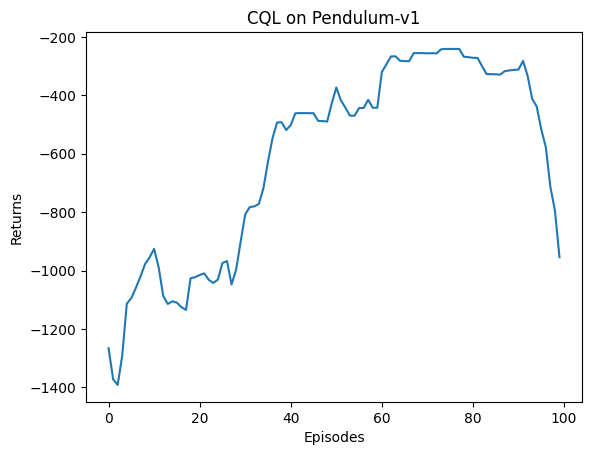

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Epochs')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('CQL on {}'.format(env_name))
plt.show()